#### For Testing the model, skip the training part. Here is [Testing.](#Testing-the-model)

### Import Libraries

In [0]:
import numpy as np
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
import tensorflow as tf
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Activation, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from collections import defaultdict
%matplotlib inline

### Load the haarcascade classifier

In [0]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

We have defined the __loadImages__ function to load the dataset and applied the Haarcascade on it. It will help in extracting the face from the images, i.e. to remove background noise. At last, I have flatten the image and stored in a list __filenames__.

### Haar Cascade Parameters Selection

1. __minNeighbors = 8__: Parameter specifying how many neighbors each candidate rectangle should have to retain it.
This parameter will affect the quality of the detected faces. Higher value results in less detections but with higher quality. Since our dataset has only 1 face per image, hence less detections with higher accuracy is more favourable. 


2. __scaleFactor = 1.01__: Parameter specifying how much the image size is reduced at each image scale.
This parameter used to specify the setp size (5% here) in multi-scale representation of an image such that the face detection can be scale-invariant. Lower the step size, slower the detction but more is the chance of getting a matching box suitable for model.


3. __minSize__ and __maxSize__ parameters are not tuned as they are not very useful in our case of constrained face data.

### Haar Cascade Drawback
It expects the face to be fully contained in the image and even if a small portion of the face is  missing, it fails out. And I don't want to add noisy data so I have removed the images that are not processed by Haar Cascade. But it is unaffordable to loose any image in such a small dataset, hence to consider all the images, I have used another face detection approach by Dlib.

In [0]:
def loadImages():
    
    imgs_array = []
    filenames=[]
    for img_file in glob.glob(os.path.join('./BioID-FaceDatabase-V1.2/', "*.pgm")):
        try:
            img = cv2.imread(img_file,0)
            (x,y,w,h) = face_detector.detectMultiScale(img, 1.01, minNeighbors=8)[0]
            face = img[y:y+h, x:x+w]
            face = cv2.resize(face,(100,100))
            imgs_array.append(face.flatten())
            filenames.append(img_file)
        except:
            print(img_file)
    return imgs_array, filenames

In [0]:
data, filenames = loadImages()
data = np.array(data)

./BioID-FaceDatabase-V1.2/BioID_1446.pgm
./BioID-FaceDatabase-V1.2/BioID_1445.pgm
./BioID-FaceDatabase-V1.2/BioID_1478.pgm
./BioID-FaceDatabase-V1.2/BioID_1481.pgm
./BioID-FaceDatabase-V1.2/BioID_1476.pgm
./BioID-FaceDatabase-V1.2/BioID_1473.pgm
./BioID-FaceDatabase-V1.2/BioID_1484.pgm
./BioID-FaceDatabase-V1.2/BioID_1449.pgm
./BioID-FaceDatabase-V1.2/BioID_0053.pgm
./BioID-FaceDatabase-V1.2/BioID_1069.pgm
./BioID-FaceDatabase-V1.2/BioID_1485.pgm
./BioID-FaceDatabase-V1.2/BioID_1447.pgm
./BioID-FaceDatabase-V1.2/BioID_0072.pgm
./BioID-FaceDatabase-V1.2/BioID_1474.pgm
./BioID-FaceDatabase-V1.2/BioID_1442.pgm
./BioID-FaceDatabase-V1.2/BioID_1174.pgm
./BioID-FaceDatabase-V1.2/BioID_1450.pgm
./BioID-FaceDatabase-V1.2/BioID_0059.pgm
./BioID-FaceDatabase-V1.2/BioID_0376.pgm
./BioID-FaceDatabase-V1.2/BioID_0146.pgm
./BioID-FaceDatabase-V1.2/BioID_0176.pgm
./BioID-FaceDatabase-V1.2/BioID_0054.pgm
./BioID-FaceDatabase-V1.2/BioID_1482.pgm
./BioID-FaceDatabase-V1.2/BioID_0060.pgm
./BioID-FaceData

#### Check the shape of the data

In [0]:
data.shape

(1494, 10000)

In [0]:
np.save('data.npy',data)

In [0]:
data = np.load('data.npy')

## KMeans Clustering

As we know that the dataset which we collected is not labled so with the help of Kmeans clustering I have made the clusters which will be helpful in labling the data. As there are 23 persons, so 23 clusters are considered.

In [0]:
kmeans = KMeans(n_clusters=23)
kmeans = kmeans.fit(data)
label = kmeans.predict(data)

Saving the images as per the labels suggested by clustering over HaarCascade processed images.

In [0]:
for i,each in enumerate(label):
    each = str(each)
    if not os.path.exists('result/'+each):
        os.makedirs('result/'+each)
    shutil.copy(filenames[i],'result/'+each+'/')

In [0]:
data = data.reshape(-1,100,100)
#x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.2)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.2)

# Face Data Iterator for triplet loss

In [0]:
def face_data_generator():
    x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.2)
    train_dict = defaultdict(lambda: [])
    for i in range(len(x_train)):
        train_dict[y_train[i]].append(x_train[i])
    for keys in train_dict:
        train_dict[keys] = np.array(train_dict[keys])
    labels = np.arange(22)
    
    while(True):
        
        sample = np.random.choice(labels, 6, replace=False)
        p_choices =np.random.choice(len(train_dict[sample[0]])-1, 10, replace=False)
        n_choices =[np.random.choice(len(train_dict[sample[i]])-1, 1, replace=False)[0] for i in range(1, 6)]
        
        positive_image = train_dict[sample[0]][p_choices].reshape(10, 100, 100, 1)
        negative_image = np.array([train_dict[sample[i]][n_choices[i-1]] for i in range(1, 6)]).reshape(5, 100, 100, 1)
        y = [sample[0] for i in range(10)]
        for i in range(1, 6):
            y.append(sample[i])
        yield np.vstack((positive_image / 255., negative_image / 255.)), np.array(y)

### Show Random Images

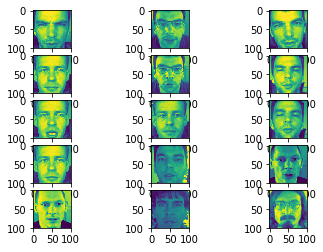

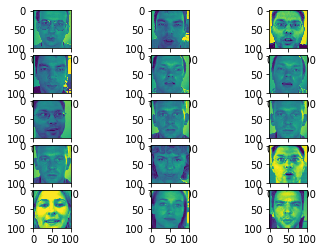

In [0]:
k = 0
x_ = None
columns = 3
rows = 5
for train, labels in face_data_generator():
    k += 1
    if k >= 3:
        break
    # Show random images
    x_ = train

    fig=plt.figure()

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(x_[i-1].reshape(100, 100))
    plt.show()

# Triplet Loss

In [0]:
def triplets_loss(y_true, y_pred):
    embeddings = y_pred
    anchor_positive = embeddings[:10]
    negative = embeddings[10:]
    dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
    square = K.square(anchor_positive)
    a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
    a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
    dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
    negative_square = K.square(negative)
    a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
    a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
    
    hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
    
    distance = (a_p_distance - hard_negative + 0.2)
    loss = K.mean(K.maximum(distance, 0.0))/(2.)

    return loss

In [0]:
test_batch = np.random.rand(15, 128)
test_batch
with K.get_session().as_default():
        print(triplets_loss(None, tf.convert_to_tensor(test_batch)).eval())





0.9107653540416356


In [0]:
def createmodel():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32))
    # Compile model
    optim = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    model.compile(loss=triplets_loss, optimizer=optim)
    model.summary()
    return model

In [0]:
model = createmodel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 49, 49, 64)        36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)       

In [0]:
model.fit_generator(face_data_generator(), steps_per_epoch=5000, epochs=10, verbose=1)

Epoch 1/10
5000/5000 [==============================] - 207s 41ms/step - loss: 2.5349
Epoch 2/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.3862
Epoch 3/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.1996
Epoch 4/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.1501
Epoch 5/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.1366
Epoch 6/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.1022
Epoch 7/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0713
Epoch 8/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0726
Epoch 9/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0578
Epoch 10/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0610


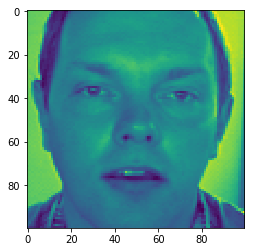

In [0]:
plt.imshow(x_test[1])

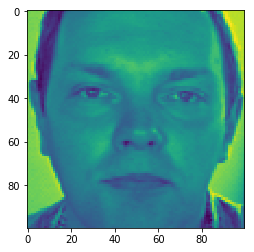

In [0]:
plt.imshow(x_test[4])

In [0]:
im1 = x_test[1]
im2 = x_test[4]
em1 = model.predict(im1.reshape((1, 100, 100, 1)))
em2 = model.predict(im2.reshape((1, 100, 100, 1)))

### Similarity Between the images

In [0]:
cosine_similarity(em1,em2)

array([[0.99703234]], dtype=float32)

#### Saving the model

In [0]:
model_json = model.to_json()
with open("triplet_loss_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("triplet_loss_model.h5")
print("Saved model to disk")

Saved model to disk


# Testing the model

In [0]:
import numpy as np
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
import tensorflow as tf
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Dropout, Activation, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from collections import defaultdict
%matplotlib inline

In [0]:
# loading the model
json_file = open('triplet_loss_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("triplet_loss_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

In [0]:
def show(im):
    plt.figure()
    plt.imshow(im[:,:,0],cmap='gray')

In [0]:
def load_img(img):
    img = cv2.imread(img,0)
    (x,y,w,h) = face_detector.detectMultiScale(img, 1.05, 8)[0] # scaleFactor = 5% to increase infernce time
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face,(100,100))
    return face.reshape(100,100,1)

In [0]:
def similarity(im1,im2):
    show(im1)
    show(im2)
    em1 = model.predict(im1.reshape((1, 100, 100, 1)))
    em2 = model.predict(im2.reshape((1, 100, 100, 1)))
    return cosine_similarity(em1,em2)

In [0]:
def compare(im1_path, im2_path):
    im1 = load_img(im1_path)
    im2 =load_img(im2_path)
    return similarity(im1,im2)

array([[0.9977798]], dtype=float32)

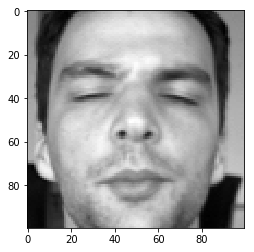

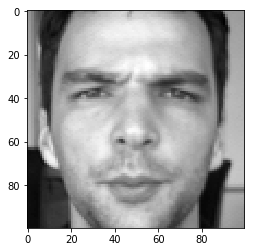

In [0]:
compare('BioID-FaceDatabase-V1.2/BioID_0003.pgm','BioID-FaceDatabase-V1.2/BioID_0001.pgm')